In [27]:
import pandas as pd
import numpy as np
import powerlaw
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
#import xgboost as xgb
import matplotlib.colors as mcolors
from tools import plot_correlation_matrix
%matplotlib inline

In [3]:
df = pd.read_csv('videogames.csv')  # Read raw data
df.head()                           # First 5 rows in data

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print('The data set includes {} unique Publishers'.format(df['Publisher'].nunique()))
print('The data set includes {} unique Developers'.format(df['Developer'].nunique()))
print('The data set includes {} genres'.format(df['Genre'].nunique()))
print('The data set includes {} platforms'.format(df['Platform'].nunique()))

The data set includes 581 unique Publishers
The data set includes 1696 unique Developers
The data set includes 12 genres
The data set includes 31 platforms


In [5]:
df.info()  # Raw info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


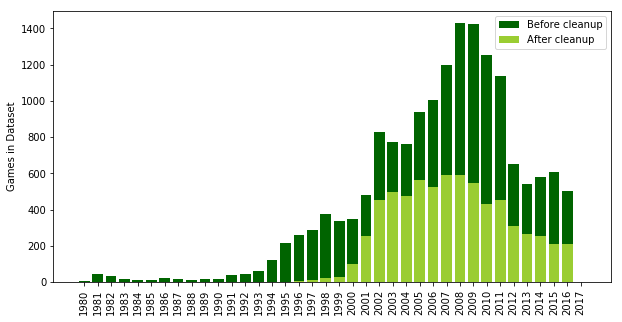

In [6]:
df = df[df['Year_of_Release'] != 2020].sort_values("Year_of_Release")

bcount = df['Year_of_Release'].dropna().value_counts().sort_index()
temp = df['Year_of_Release'].dropna().value_counts().sort_index()
acount = df.dropna(axis=0, how='any')['Year_of_Release'].value_counts().sort_index()
years = bcount.index.astype(int)


for i in bcount.index:
    if i not in acount.index:
        acount[i] = 0
acount.sort_index(inplace=True)

fig = plt.figure(figsize=(10,5))
plt.bar(range(len(bcount)), bcount, label='Before cleanup', tick_label=years, color = (0,100/255,0))
plt.bar(range(len(acount)), acount, label='After cleanup', color = 	(154/255,205/255,50/255))
plt.legend()
plt.xticks(rotation=90, ha='center')
plt.ylabel('Games in Dataset')
fig.savefig("cleanup.pdf", bbox_inches='tight') 


In [7]:
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')*10 # Convert User Score to double and normalize it to match Critic Score
df = df.dropna(axis=0, how='any')  # Eliminate rows if they contain any NaN value
df.info()                          # Info without NaN values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 14472 to 5320
Data columns (total 16 columns):
Name               6825 non-null object
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Other_Sales        6825 non-null float64
Global_Sales       6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null float64
User_Count         6825 non-null float64
Developer          6825 non-null object
Rating             6825 non-null object
dtypes: float64(10), object(6)
memory usage: 906.4+ KB


In [8]:
df.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.394484,0.236089,0.064158,0.082677,0.777590,70.272088,28.931136,71.856264,174.722344
std,4.211248,0.967385,0.687330,0.287570,0.269871,1.963443,13.868572,19.224165,14.399417,587.428538
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75.000000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.750000,80.000000,39.000000,82.000000,89.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


### Correlation Matrix

In [28]:
correlation = df.corr()
print(np.array(df.keys()))
attributes = ['Year of Release','NA Sales','EU Sales','JP Sales','Other Sales','Global Sales','Critic Score','Critic Count','User Score','User Count']

cmap='RdBu'
plot_correlation_matrix(correlation.as_matrix(), attributes, title='Numerical Features Correlation Matrix', cmap=cmap,figsize=(10,8),
                       savename='correlationMatrix.pdf')

['Name' 'Platform' 'Year_of_Release' 'Genre' 'Publisher' 'NA_Sales'
 'EU_Sales' 'JP_Sales' 'Other_Sales' 'Global_Sales' 'Critic_Score'
 'Critic_Count' 'User_Score' 'User_Count' 'Developer' 'Rating']


TypeError: plot_correlation_matrix() got an unexpected keyword argument 'savename'

### Scores

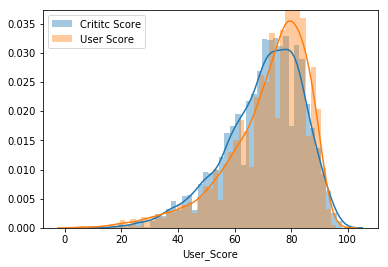

In [8]:
newdf = df[['Critic_Score', 'User_Score']].dropna(axis=0)
sns.distplot(newdf['Critic_Score'], label='Crititc Score')
sns.distplot(newdf['User_Score'], label='User Score')
plt.legend()
plt.show()

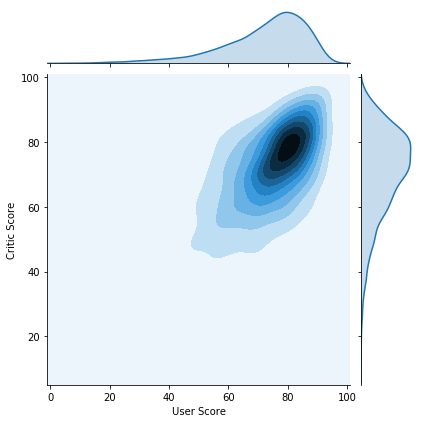

In [9]:
plot = sns.jointplot(x="User_Score", y="Critic_Score", data=newdf, kind="kde", stat_func=None, xlim=(-1,101), ylim=(5,101))
plot.set_axis_labels('User Score', 'Critic Score')

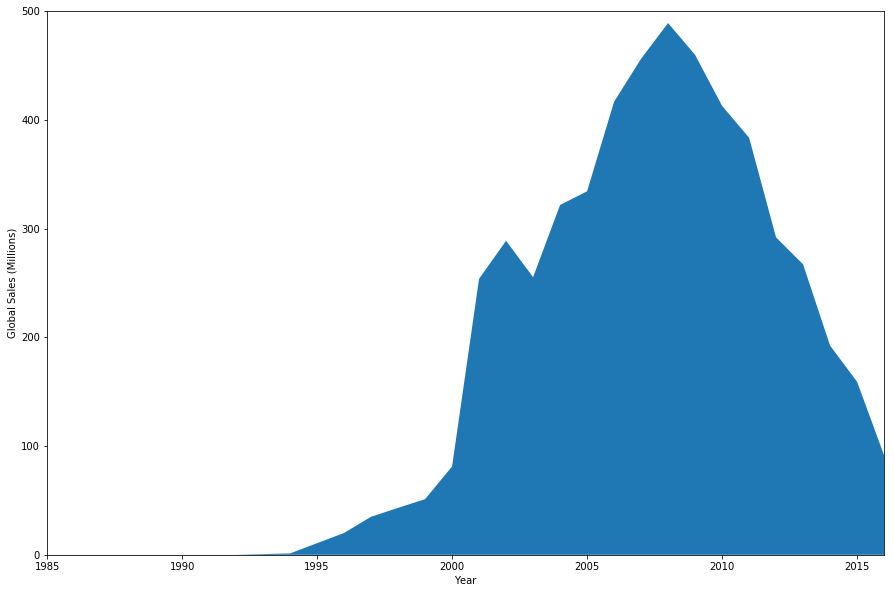

In [66]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = [ np.sum( df['Global_Sales'][np.array((df['Year_of_Release']==year).tolist())].tolist() )   for year in years]

fig = plt.figure(figsize=(15,10))
plt.xlim(1985,2016)
plt.ylim(0,500)
plt.xlabel('Year')
plt.ylabel('Global Sales (Millions)')
plt.stackplot(years,sales)

fig.savefig("salesYear.pdf", bbox_inches='tight') 

### Popular Genre

      Action has 1203.16 million sales and 1630 entries in the database
      Sports has  833.85 million sales and  943 entries in the database
     Shooter has  816.48 million sales and  864 entries in the database
Role-Playing has  501.37 million sales and  712 entries in the database
      Racing has  476.22 million sales and  581 entries in the database
    Platform has  377.80 million sales and  403 entries in the database
    Fighting has  249.95 million sales and  378 entries in the database
  Simulation has  202.70 million sales and  297 entries in the database
   Adventure has   80.75 million sales and  248 entries in the database
      Puzzle has   78.90 million sales and  118 entries in the database
    Strategy has   69.61 million sales and  267 entries in the database
        Misc has  416.26 million sales and  384 entries in the database


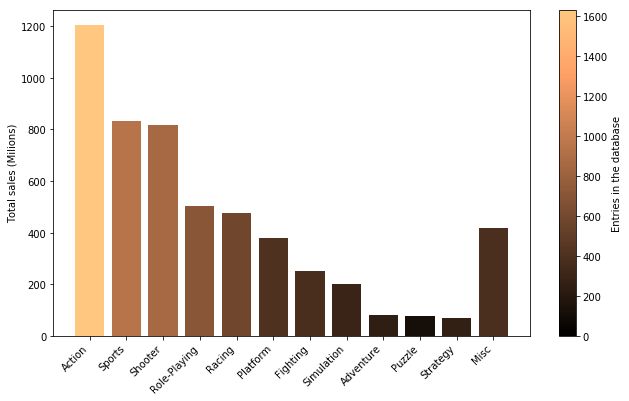

In [10]:
genres =['Action', 'Sports', 'Shooter', 'Role-Playing', 'Racing', 'Platform',
         'Fighting', 'Simulation', 'Adventure', 'Puzzle', 'Strategy', 'Misc']

genres = sorted(genres, key=lambda g: np.sum(df['Global_Sales'][df['Genre'] == g]), reverse=True)
genres.remove('Misc')
genres.append('Misc')

sales = [np.sum(df['Global_Sales'][df['Genre'] == genre]) for genre in genres]
count = np.array([df['Genre'].value_counts()[genre] for genre in genres])

for genre in genres:
    print('{:>12} has {:>7.2f} million sales and {:>4} entries in the database'.format(
           genre,
           np.sum(df['Global_Sales'][df['Genre'] == genre]),
           df['Genre'].value_counts()[genre]))
    
plt.figure(figsize=(16/1.5,6))
    
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=count.max())
colormap = plt.get_cmap('copper')

# setup the colorbar
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(count)
plt.colorbar(scalarmappaple, label = 'Entries in the database')

plt.bar(range(len(genres)), sales, tick_label=genres, color=colormap(normalize(count)))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total sales (Milions)')
plt.show()

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


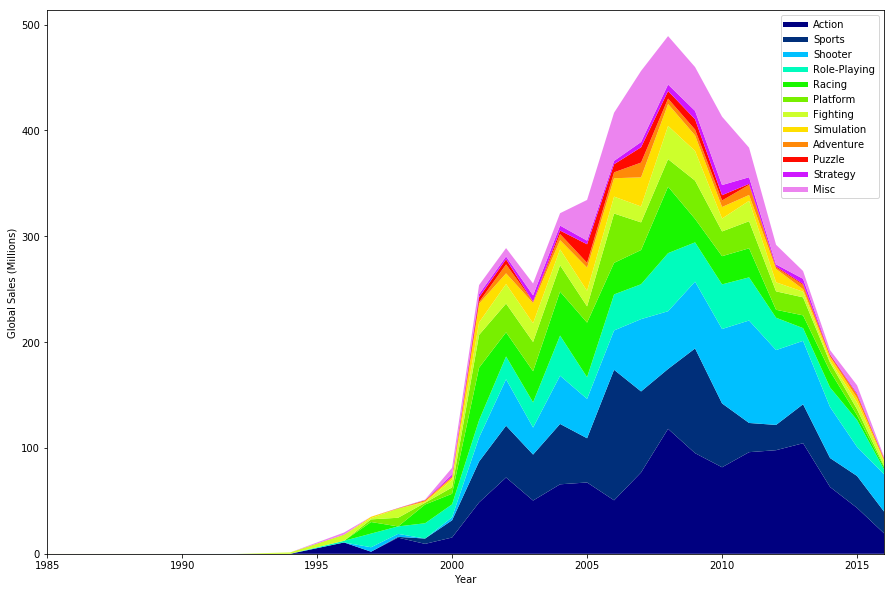

In [67]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = [[ np.sum( df['Global_Sales'][np.logical_and(np.array((df['Genre']==genre).tolist()),np.array((df['Year_of_Release']==year).tolist()))].tolist() )   for year in years] for genre in genres]

fig = plt.figure(figsize=(15,10))
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 12)])
for i in range(len(genres)):
    plt.plot([],[],label=genres[i],linewidth=5)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Global Sales (Millions)')
plt.xlim(1985,2016)
plt.stackplot(years,sales)

fig.savefig("genreYear.pdf", bbox_inches='tight') 

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


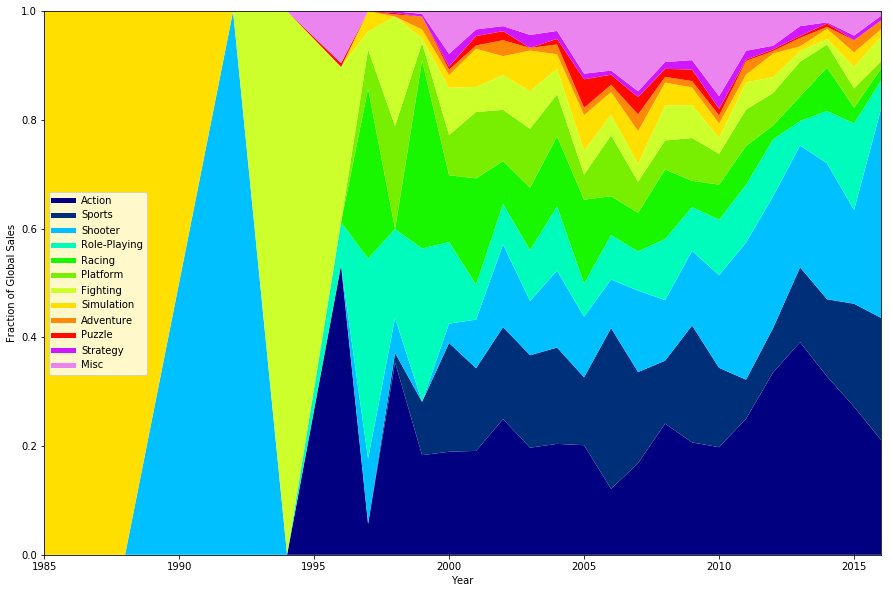

In [68]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = [[ np.sum( df['Global_Sales'][np.logical_and(np.array((df['Genre']==genre).tolist()),np.array((df['Year_of_Release']==year).tolist()))].tolist() )/
          np.sum( df['Global_Sales'][(df['Year_of_Release']==year).tolist()].tolist() )
          for year in years] for genre in genres]

fig = plt.figure(figsize=(15,10))
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 12)])
for i in range(len(genres)):
    plt.plot([],[],label=genres[i],linewidth=5)
plt.legend(loc='center left')
plt.xlabel('Year')
plt.ylabel('Fraction of Global Sales')
plt.ylim(0,1)
plt.xlim(1985,2016)
plt.stackplot(years,sales)

fig.savefig("genreYearFraction.pdf", bbox_inches='tight') 

### Popular Platform

 PS2 has  945.97 million sales and 1140 entries in the database
X360 has  853.30 million sales and  858 entries in the database
 PS3 has  784.30 million sales and  769 entries in the database
 Wii has  658.98 million sales and  479 entries in the database
  DS has  382.33 million sales and  464 entries in the database
 PS4 has  243.03 million sales and  239 entries in the database
  XB has  212.07 million sales and  565 entries in the database
  PS has  206.55 million sales and  150 entries in the database
 PSP has  187.92 million sales and  390 entries in the database
  PC has  187.12 million sales and  651 entries in the database
  GC has  159.42 million sales and  348 entries in the database
 GBA has  131.75 million sales and  237 entries in the database
XOne has  129.57 million sales and  159 entries in the database
 3DS has  123.23 million sales and  155 entries in the database
WiiU has   66.08 million sales and   89 entries in the database
 PSV has   30.88 million sales and  118 

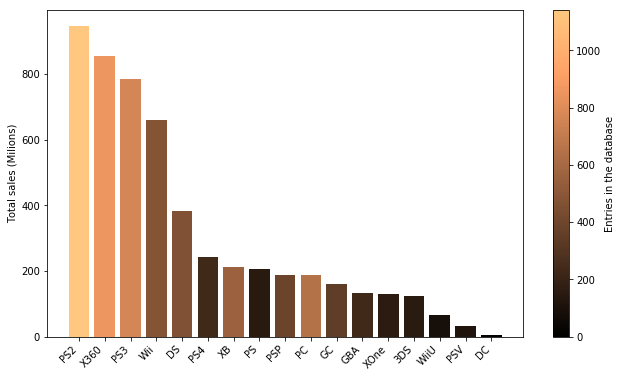

In [12]:
platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS4', 'XB', 'PS', 'PSP', 'PC',
            'GC', 'GBA', 'XOne', '3DS', 'WiiU', 'PSV', 'DC']

platforms = sorted(platforms, key=lambda p: np.sum(df['Global_Sales'][df['Platform'] == p]), reverse=True)

sales = [np.sum(df['Global_Sales'][df['Platform'] == platform]) for platform in platforms]
count = np.array([df['Platform'].value_counts()[platform] for platform in platforms])

for platform in platforms:
    print('{:>4} has {:>7.2f} million sales and {:>4} entries in the database'.format(
           platform,
           np.sum(df['Global_Sales'][df['Platform'] == platform]),
           df['Platform'].value_counts()[platform]))
    
plt.figure(figsize=(16/1.5,6))
    
# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=0, vmax=count.max())
colormap = plt.get_cmap('copper')

# setup the colorbar
scalarmappaple = plt.cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(count)
plt.colorbar(scalarmappaple, label = 'Entries in the database')

plt.bar(range(len(platforms)), sales, tick_label=platforms, color=colormap(normalize(count)))
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total sales (Milions)')
plt.show()

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


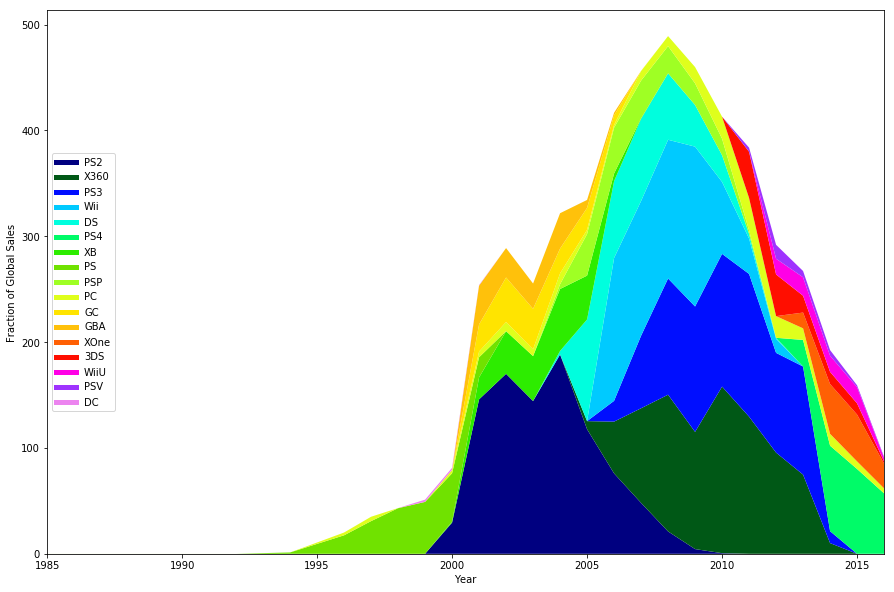

In [69]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = [[ np.sum( df['Global_Sales'][np.logical_and(np.array((df['Platform']==platform).tolist()),np.array((df['Year_of_Release']==year).tolist()))].tolist() ) for year in years] for platform in platforms]

fig = plt.figure(figsize=(15,10))
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 17)])
for i in range(len(platforms)):
    plt.plot([],[],label=platforms[i],linewidth=5)
plt.legend(loc='center left')
plt.xlabel('Year')
plt.ylabel('Fraction of Global Sales')
plt.xlim(1985,2016)
plt.stackplot(years,sales)
fig.savefig("platformYear.pdf", bbox_inches='tight') 

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


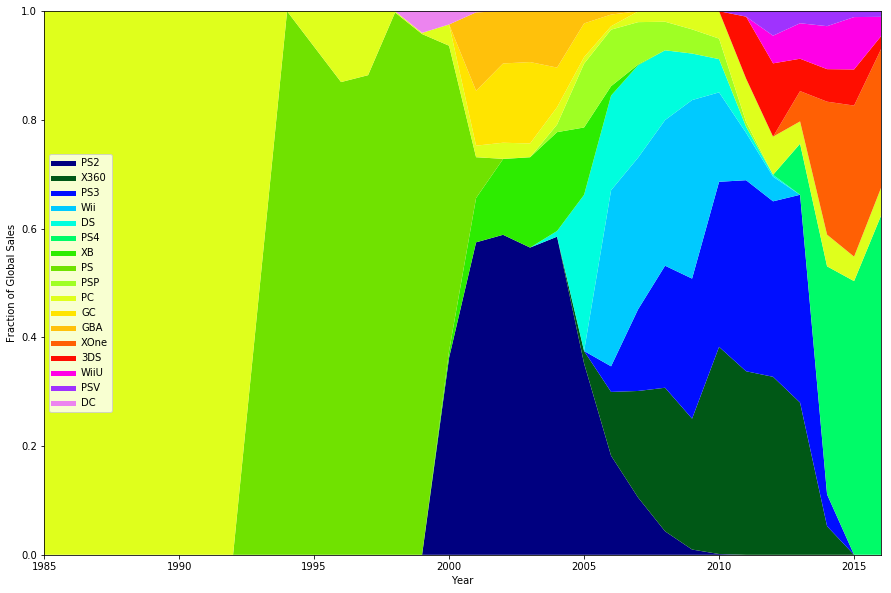

In [71]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = [[ np.sum( df['Global_Sales'][np.logical_and(np.array((df['Platform']==platform).tolist()),np.array((df['Year_of_Release']==year).tolist()))].tolist() ) /
          np.sum( df['Global_Sales'][ np.array((df['Year_of_Release']==year).tolist())].tolist() )
          for year in years] for platform in platforms]

fig = plt.figure(figsize=(15,10))
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, 17)])
for i in range(len(platforms)):
    plt.plot([],[],label=platforms[i],linewidth=5)
plt.legend(loc='center left')
plt.xlabel('Year')
plt.ylabel('Fraction of Global Sales')
plt.ylim(0,1)
plt.xlim(1985,2016)
plt.stackplot(years,sales)
fig.savefig("platformYearFraction.pdf", bbox_inches='tight') 

### Years

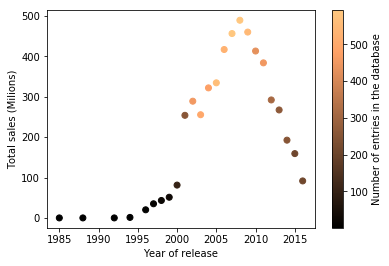

In [14]:
years = sorted(df['Year_of_Release'].value_counts().index)
sales = []

for y in years:
    sales.append(np.sum(df['Global_Sales'][df['Year_of_Release'] == y]))

counts = df['Year_of_Release'].value_counts()
colors = [counts[i] for i in years]

plt.set_cmap('copper')
plt.scatter(years, sales, c=colors)
cb = plt.colorbar()
plt.xlabel('Year of release')
plt.ylabel('Total sales (Milions)')
cb.set_label('Number of entries in the database')
plt.show()

### Region wise sales

In [17]:
sales = [[ np.sum( df['Global_Sales'][np.logical_and(np.array((df['Genre']==genre).tolist()),np.array((df['Year_of_Release']==year).tolist()))].tolist() ) / np.sum(df['Global_Sales'][np.array((df['Year_of_Release']==year).tolist())])   for year in years] for genre in genres]

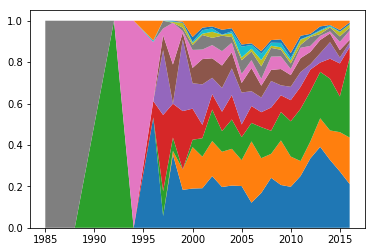

In [18]:
plt.stackplot(sorted(df['Year_of_Release'].value_counts().index), sales)

In [20]:
sports =  np.sum( df['Global_Sales'][np.logical_and(np.array((df['Genre']=='Sports').tolist()),np.array((df['Year_of_Release']==1997).tolist()))] ) / np.sum(df['Global_Sales'][np.array((df['Year_of_Release']==1997).tolist())])
print(np.sum(df['Global_Sales'][np.array((df['Year_of_Release']==1997).tolist())]))

35.01


In [16]:
def func(x):
    a = zip(x.index, x.values)
    a = np.array(sorted(a))
    return a[:,0], np.cumsum(a[:,1])/len(df)

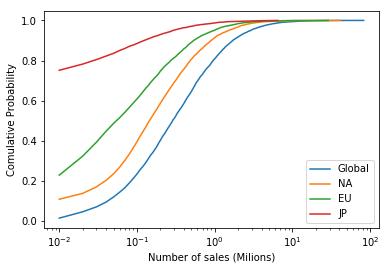

In [17]:
x = df['Global_Sales'].value_counts()
plt.plot(*func(x), label='Global')
x = df['NA_Sales'].value_counts()
plt.plot(*func(x), label='NA')
x = df['EU_Sales'].value_counts()
plt.plot(*func(x), label='EU')
x = df['JP_Sales'].value_counts()
plt.plot(*func(x), label='JP')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.ylabel('Comulative Probability')
plt.xlabel('Number of sales (Milions)')
plt.show()

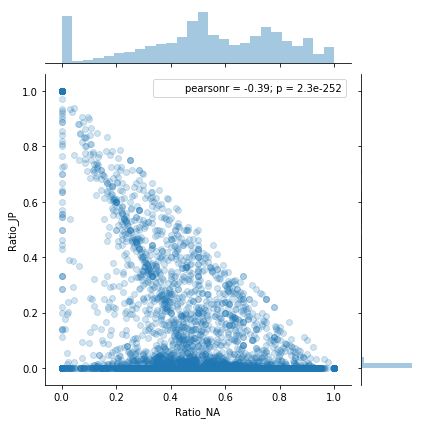

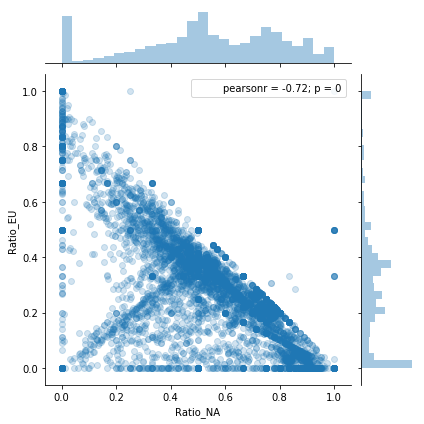

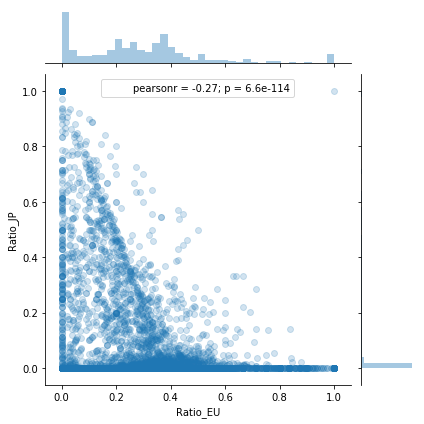

In [18]:
df['Ratio_NA'] = df['NA_Sales']/df['Global_Sales']
df['Ratio_EU'] = df['EU_Sales']/df['Global_Sales']
df['Ratio_JP'] = df['JP_Sales']/df['Global_Sales']
df['Ratio_Other'] = df['Other_Sales']/df['Global_Sales']
sns.jointplot(x="Ratio_NA", y="Ratio_JP", data=df, alpha=0.2)
sns.jointplot(x="Ratio_NA", y="Ratio_EU", data=df, alpha=0.2)
sns.jointplot(x="Ratio_EU", y="Ratio_JP", data=df, alpha=0.2)

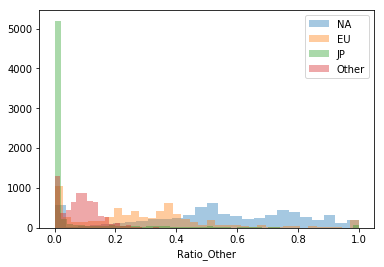

In [19]:
sns.distplot(df['Ratio_NA'], label='NA', kde=False)
sns.distplot(df['Ratio_EU'], label='EU', kde=False)
sns.distplot(df['Ratio_JP'], label='JP', kde=False)
sns.distplot(df['Ratio_Other'], label='Other', kde=False)
plt.legend()
plt.show()

### Shit

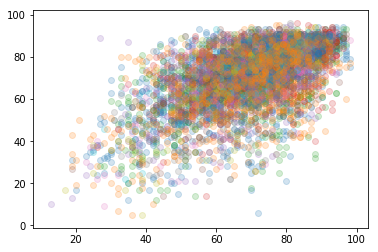

In [117]:
for g in genres:
    plt.scatter(df['Critic_Score'][df['Genre'] == g], df['User_Score'][df['Genre'] == g], alpha=0.2)
plt.show()

## Classification

train/test split

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

features = ['Year_of_Release', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count']

classes = df['Platform']
dropped = df[['Year_of_Release', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count']]

x_train, x_test, y_train, y_test = train_test_split(dropped, classes, test_size=0.2, random_state=69)

DimensionalityReduction = LinearDiscriminantAnalysis()
#DimensionalityReduction = PCA()
DimensionalityReduction.fit(x_train,y_train)
x_train = DimensionalityReduction.transform(x_train)
x_test = DimensionalityReduction.transform(x_test)

accuracy 2.34%
train accuracy 2.16%


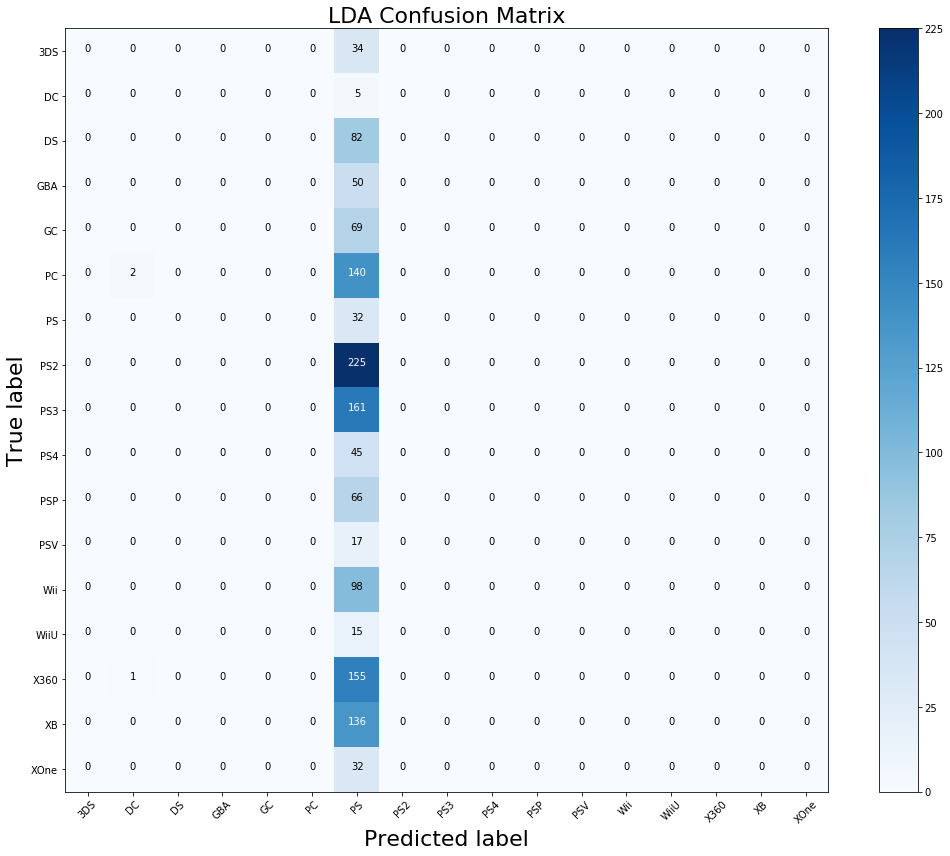

In [141]:
cm = confusion_matrix(y_test, DimensionalityReduction.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, DimensionalityReduction.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, DimensionalityReduction.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=DimensionalityReduction.classes_, title='LDA Confusion Matrix')
plt.savefig('LDAConfusionMatrixLDA.pdf')

### Knn

In [142]:
from tools import plot_confusion_matrix, gen_log_space, cross_validate_model
from sklearn.metrics import confusion_matrix, accuracy_score

In [143]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = gen_log_space(limit=1000, n=70)[1:]#range(1, 2000, 100)

print(neighbors)

train_results, test_results = [], []


for i, n in enumerate(neighbors):
    print('{:.1f}%'.format((i/len(neighbors))**2*100), end='\r')
    model = KNeighborsClassifier(n_neighbors=n)

    test, train = cross_validate_model(model, x_train, y_train)
    train_results.append(train[0])
    test_results.append(test[0])

print('done')

#np.sum(df['Platform'] == 'PS2') / len(dropped)

    
#cross_validate(model, x_train, y_train, return_train_score=True)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  20
  21  23  25  27  29  31  34  37  40  43  46  50  54  59  63  68  74  80
  86  93 101 109 117 127 137 148 160 172 186 201 217 234 253 273 295 318
 343 370 400 432 466 503 543 586 632 682 736 795 858 926 999]
done%


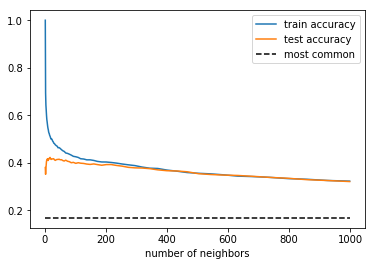

In [144]:
plt.plot(neighbors, train_results, label='train accuracy')
plt.plot(neighbors, test_results, label='test accuracy')
plt.plot(neighbors, [np.sum(y_train == 'PS2') / len(y_train)] * len(neighbors), 'k--', label='most common')
#plt.xscale('log')
plt.xlabel('number of neighbors')
plt.legend()
#plt.ylim(-0.1,1.1)
#plt.yscale('log')

plt.savefig('knn_neighborsLDA.pdf')
plt.show()

best test result for 17 neighbours
accuracy 44.98%
train accuracy 52.16%


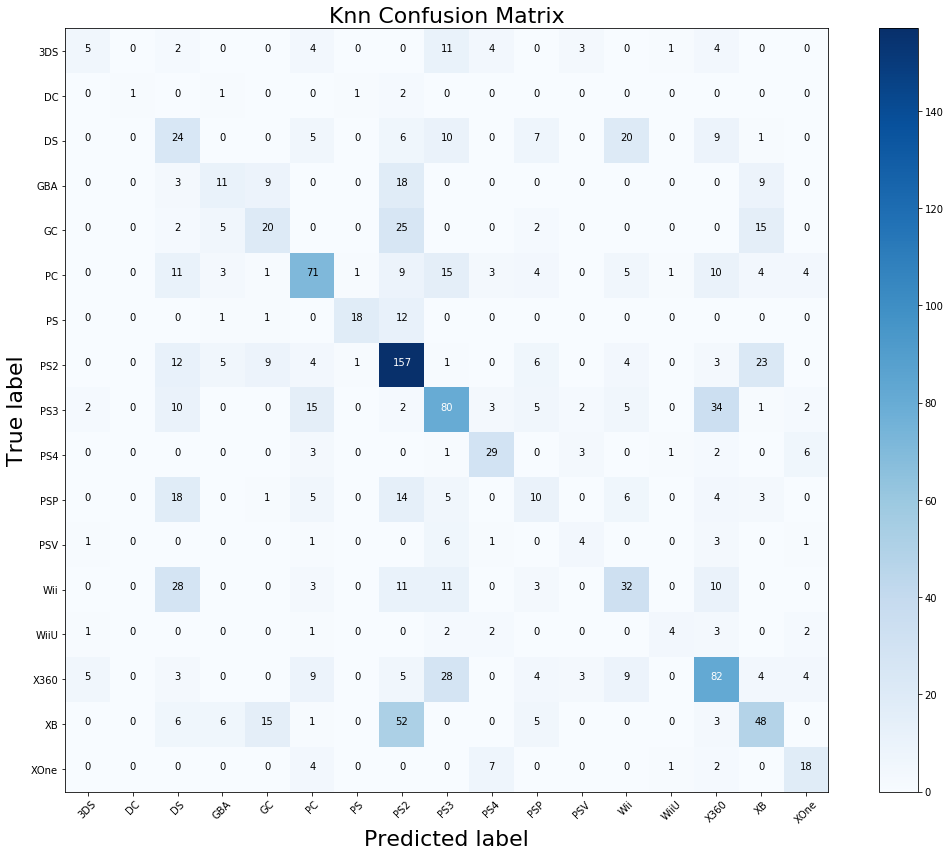

In [145]:
print('best test result for {} neighbours'.format(neighbors[np.argmax(test_results)]))

model = KNeighborsClassifier(n_neighbors=neighbors[np.argmax(test_results)])
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Knn Confusion Matrix')
plt.savefig('KnnConfusionMatrixLDA.pdf')

### Naive Bayes

accuracy 31.50%
train accuracy 32.03%


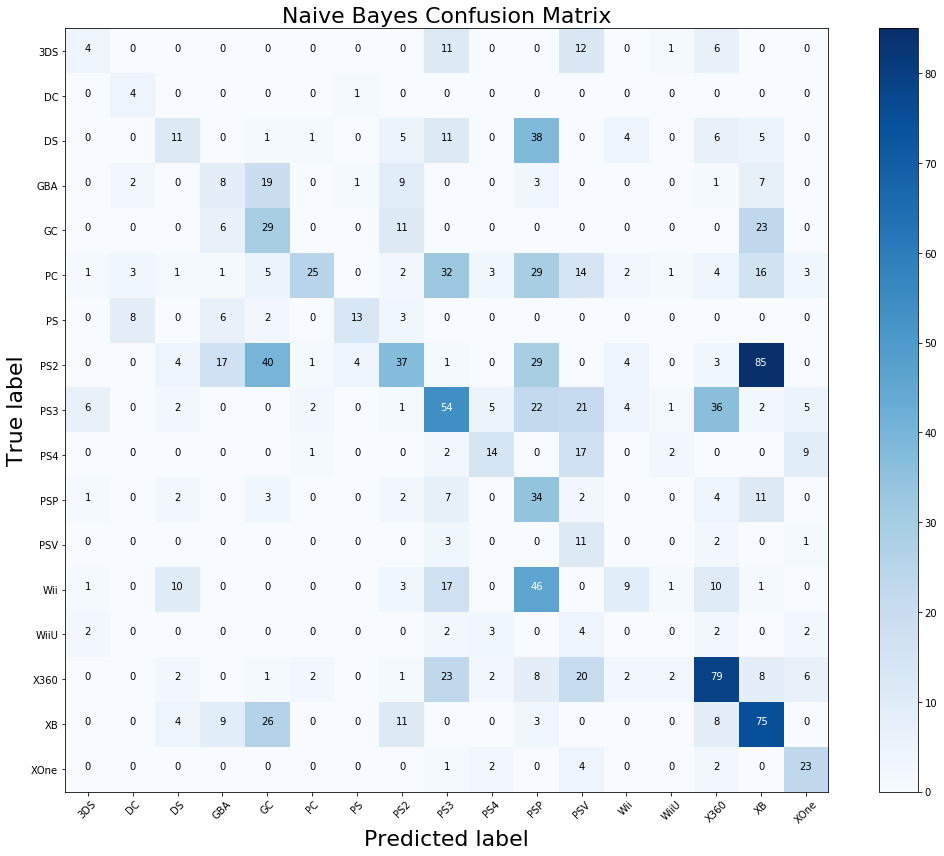

In [146]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Naive Bayes Confusion Matrix')
plt.savefig('NaiveBayesConfusionMatrixLDA.pdf')

### Decision Tree

In [147]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

depth = range(1,25)

train_results, test_results = [], []


for i, n in enumerate(depth):
    print('{:.1f}%'.format((i/len(depth))*100), end='\r')
    model = DecisionTreeClassifier(max_depth=n)

    test, train = cross_validate_model(model, x_train, y_train)
    train_results.append(train[0])
    test_results.append(test[0])

print('done')

done%


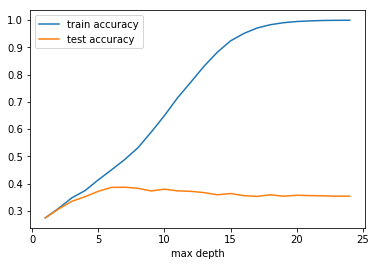

In [148]:
plt.plot(depth, train_results, label='train accuracy')
plt.plot(depth, test_results, label='test accuracy')
#plt.plot(depth, [np.sum(y_train == 'PS2') / len(y_train)] * len(neighbors), 'k--', label='most common')
#plt.xscale('log')
plt.xlabel('max depth')
plt.legend()
#plt.ylim(-0.1,1.1)
#plt.yscale('log')

plt.savefig('DecisionTreeDepthLDA.pdf')
plt.show()

best test result for 7 max_depth
accuracy 38.68%
train accuracy 46.56%


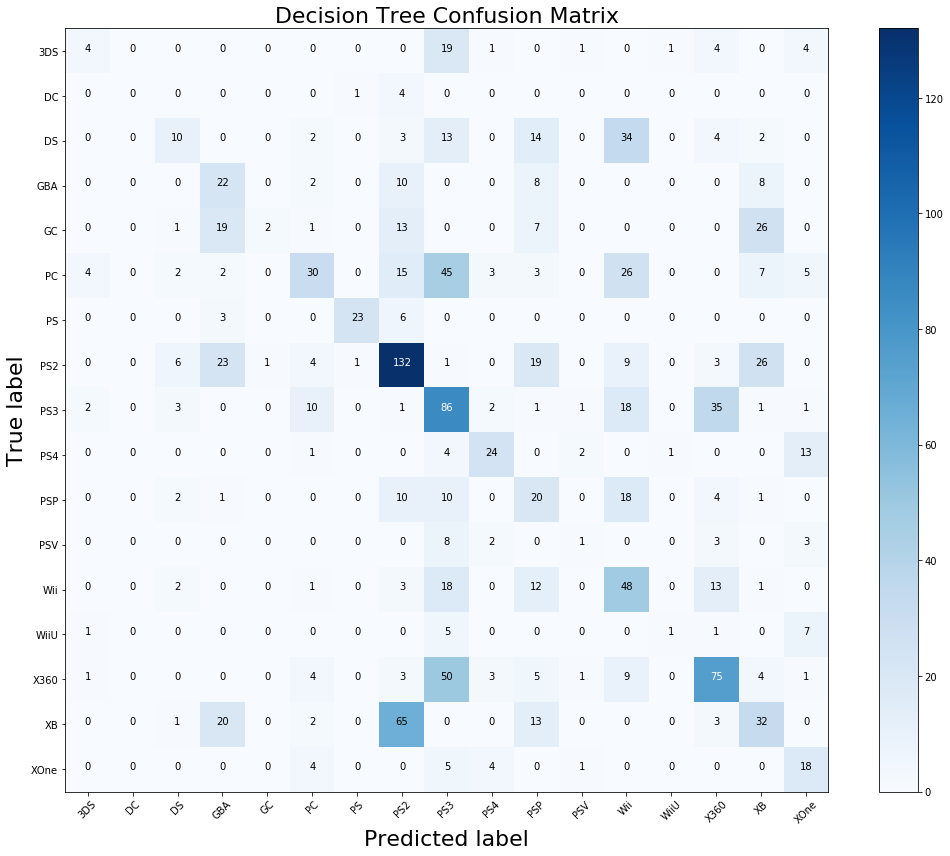

In [149]:
print('best test result for {} max_depth'.format(depth[np.argmax(test_results)]))

model = DecisionTreeClassifier(max_depth=depth[np.argmax(test_results)])
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Decision Tree Confusion Matrix')
plt.savefig('DecisionTreeConfusionMatrixLDA.pdf')

### Curiosity

In [150]:
model = DecisionTreeClassifier(max_depth=12)
model.fit(x_train, y_train)
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
data = export_graphviz(model, out_file=None, feature_names=features,
                       class_names=model.classes_, rounded=True,
                       filled=True, special_characters=True, max_depth=4)
import graphviz

graph = graphviz.Source(data)
graph.render('stuff')

accuracy 38.90%


'stuff.pdf'

### Random Forest

In [151]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

depth = range(1,25)

train_results, test_results = [], []


for i, n in enumerate(depth):
    print('{:.1f}%'.format((i/len(depth))*100), end='\r')
    model = RandomForestClassifier(max_depth=n)

    test, train = cross_validate_model(model, x_train, y_train)
    train_results.append(train[0])
    test_results.append(test[0])

print('done')

done%


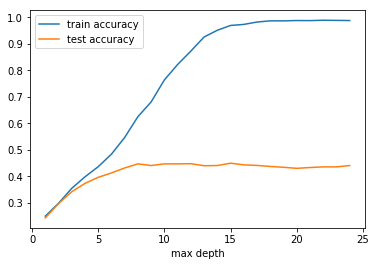

In [152]:
plt.plot(depth, train_results, label='train accuracy')
plt.plot(depth, test_results, label='test accuracy')
#plt.plot(depth, [np.sum(y_train == 'PS2') / len(y_train)] * len(neighbors), 'k--', label='most common')
#plt.xscale('log')
plt.xlabel('max depth')
plt.legend()
#plt.ylim(-0.1,1.1)
#plt.yscale('log')

plt.savefig('RandomForestLDA.pdf')
plt.show()

best test result for 15 max_depth
accuracy 38.32%
train accuracy 88.41%


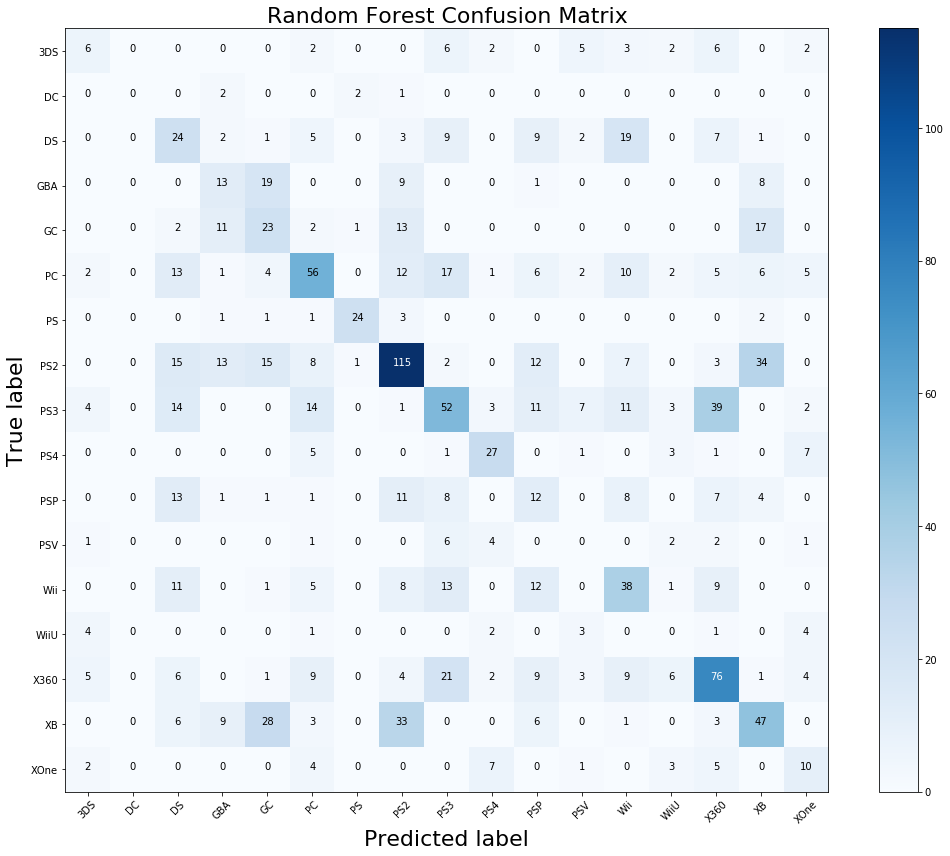

In [153]:
print('best test result for {} max_depth'.format(depth[np.argmax(test_results)]))

model = DecisionTreeClassifier(max_depth=depth[np.argmax(test_results)])
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Random Forest Confusion Matrix')
plt.savefig('RandomForestConfusionMatrixLDA.pdf')

### Gradient Boosting

accuracy 50.84%
train accuracy 80.22%


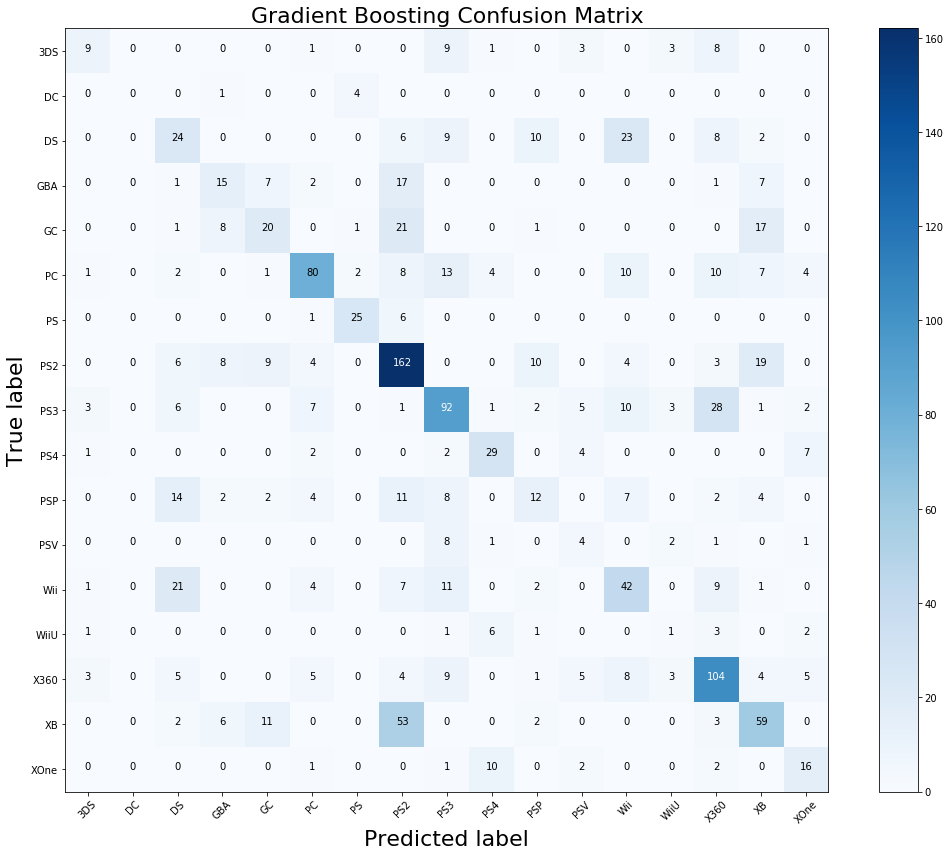

In [154]:
model = GradientBoostingClassifier()
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Gradient Boosting Confusion Matrix')
plt.savefig('GradientBoostingConfusionMatrixLDA.pdf')

### Support Vector Machines

accuracy 59.78%
train accuracy 61.17%


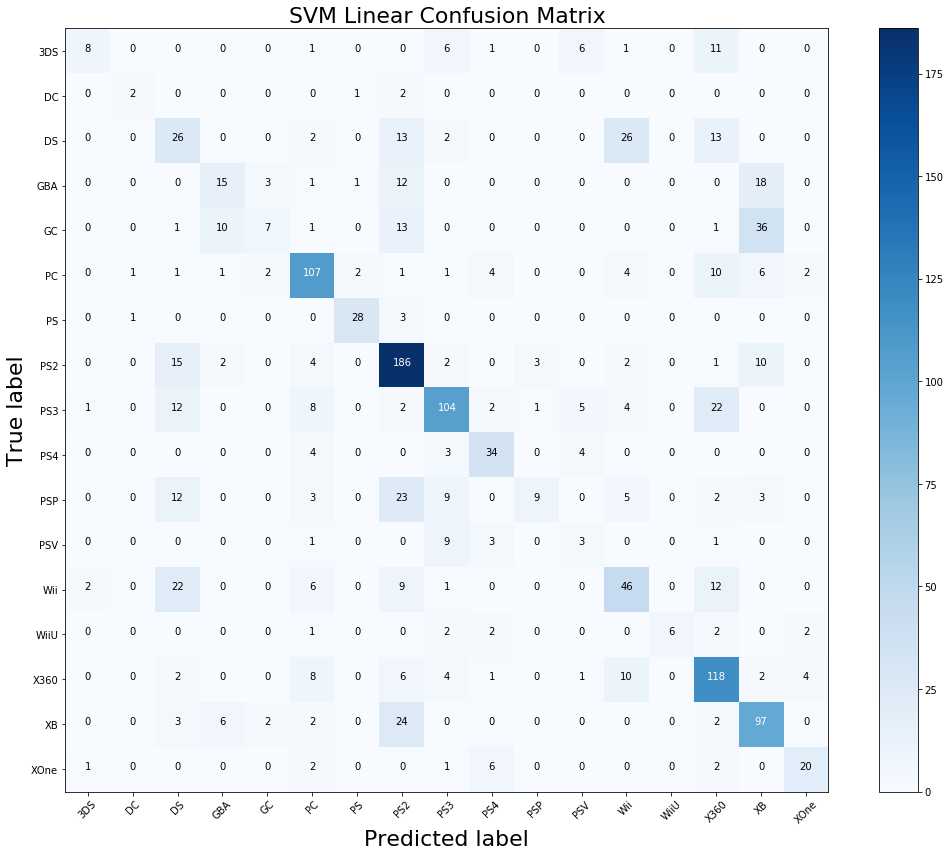

In [155]:
from sklearn.svm import SVC#, LinearSVC

model = SVC(decision_function_shape='ovr', kernel='linear')

model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='SVM Linear Confusion Matrix')
plt.savefig('SVMLinearConfusionMatrixLDA.pdf')

In [162]:
from sklearn.model_selection import GridSearchCV

Cs = [10]
gammas = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, n_jobs=-1, verbose=2, return_train_score=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.001, C=10 ...............................................
[CV] gamma=0.001, C=10 ...............................................
[CV] gamma=0.001, C=10 ...............................................
[CV] gamma=0.01, C=10 ................................................
[CV] gamma=0.01, C=10 ................................................
[CV] gamma=0.01, C=10 ................................................
[CV] gamma=0.1, C=10 .................................................
[CV] gamma=0.1, C=10 .................................................
[CV] ................................. gamma=0.01, C=10, total=   1.1s
[CV] gamma=0.1, C=10 .................................................
[CV] ................................. gamma=0.01, C=10, total=   1.1s
[CV] gamma=1, C=10 ...................................................
[CV] ................................. gamma=0.01, C=10, total=   1.2s
[CV] gamma=1, C=1

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.4s remaining:    2.1s


[CV] .................................. gamma=0.1, C=10, total=   1.1s
[CV] .................................... gamma=1, C=10, total=   3.6s
[CV] .................................... gamma=1, C=10, total=   3.7s
[CV] .................................... gamma=1, C=10, total=   3.6s
[CV] ................................... gamma=10, C=10, total=   5.0s
[CV] ................................... gamma=10, C=10, total=   5.0s
[CV] ................................... gamma=10, C=10, total=   5.4s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.6s finished


{'C': 10, 'gamma': 0.1}

In [163]:
list(zip(grid_search.cv_results_['params'],grid_search.cv_results_['std_test_score']))

[({'C': 10, 'gamma': 0.001}, 0.0051172230490349763),
 ({'C': 10, 'gamma': 0.01}, 0.01130569663864988),
 ({'C': 10, 'gamma': 0.1}, 0.0040517263268262721),
 ({'C': 10, 'gamma': 1}, 0.006642426527876639),
 ({'C': 10, 'gamma': 10}, 0.0020322677868581766)]

accuracy 53.55%
train accuracy 59.65%


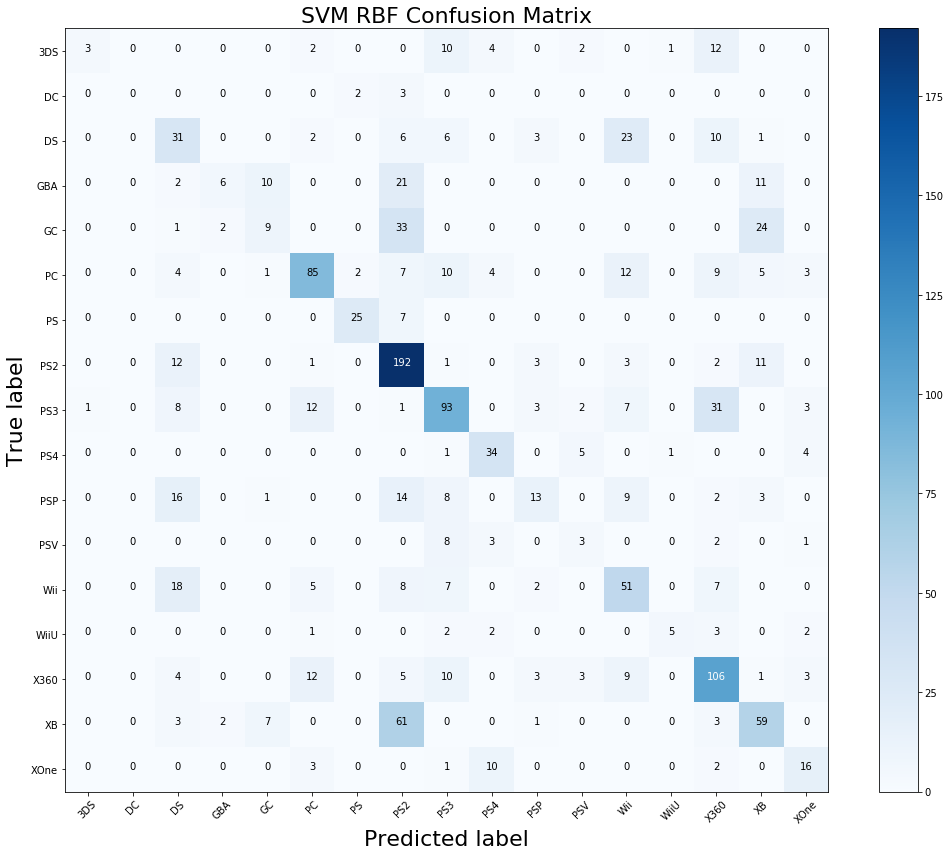

In [159]:
model = SVC(decision_function_shape='ovr', kernel='rbf', gamma=0.1)

model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='SVM RBF Confusion Matrix')
plt.savefig('SVMRbfConfusionMatrixLDA.pdf')

### Feature adding

In [36]:
for x in (x_train, x_test):
    x['Ratio_NA'] = x['NA_Sales']/x['Global_Sales']
    x['Ratio_EU'] = x['EU_Sales']/x['Global_Sales']
    x['Ratio_JP'] = x['JP_Sales']/x['Global_Sales']
    x['Ratio_Other'] = x['Other_Sales']/x['Global_Sales']
    x['Ratio_Score'] = x['User_Score']/x['Critic_Score']
    x['Ratio_Count'] = x['User_Count']/x['Critic_Count']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

accuracy 72.01%
train accuracy 92.47%


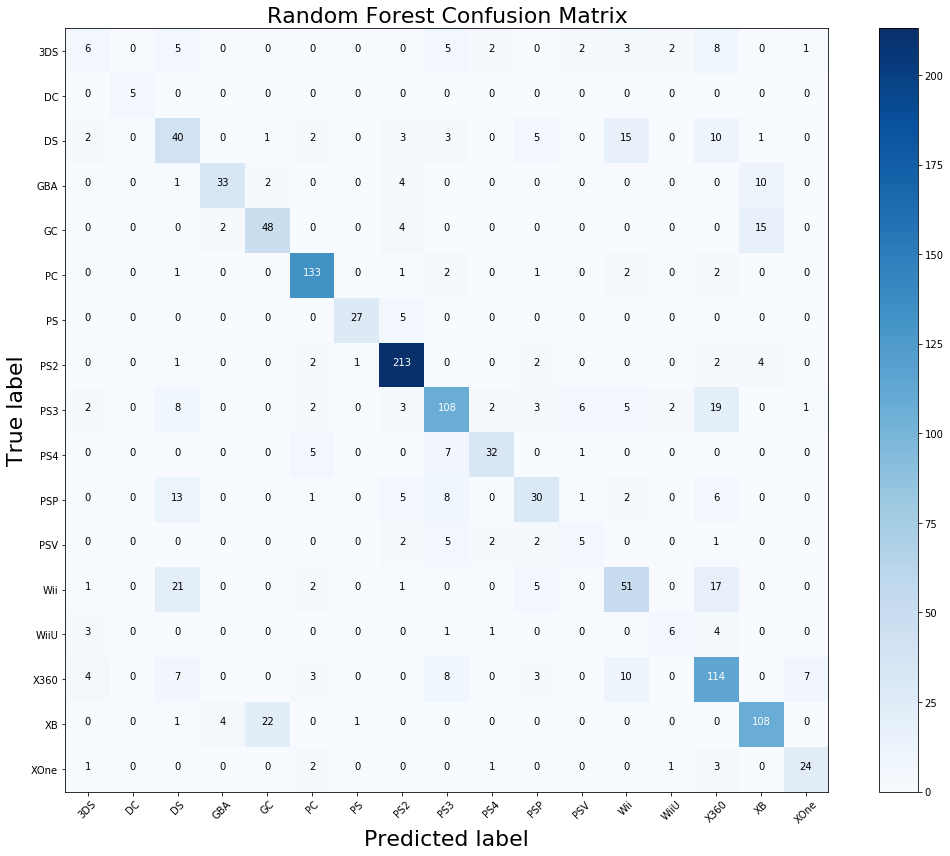

In [39]:
model =  RandomForestClassifier(max_depth=12)
model.fit(x_train, y_train)

cm = confusion_matrix(y_test, model.predict(x_test))
print('accuracy {:.2f}%'.format(accuracy_score(y_test, model.predict(x_test))*100))
print('train accuracy {:.2f}%'.format(accuracy_score(y_train, model.predict(x_train))*100))
#print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Random Forest Confusion Matrix')
plt.savefig('RandomForest+ConfusionMatrix.pdf')

# from here down it's all shit

In [18]:
df['Rating'].value_counts()

T       2377
E       2082
M       1433
E10+     930
K-A        1
AO         1
RP         1
AO         1
Name: Rating, dtype: int64

In [19]:
#print(PCA_.explained_variance_)
#print(PCA_.explained_variance_ratio_)
#print(LDA.explained_variance_ratio_)

In [20]:


from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#model = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')
#model = SVC(decision_function_shape='ovr', kernel='linear', verbose=2) #slow and shit
#model = GaussianNB()
#model = RandomForestClassifier(class_weight = 'balanced', criterion='entropy', n_estimators=100, max_features=None, n_jobs=-1)
model = xgb.XGBClassifier(max_depth=6, n_estimators=100, n_jobs=8)
#model = GradientBoostingClassifier(max_depth=6, n_estimators=100)

model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [21]:
a = list(zip(dropped.columns,model.feature_importances_))
sorted(a, key=lambda x: x[1], reverse=True)

[('Year_of_Release', 0.12254094),
 ('Ratio_Other', 0.10796532),
 ('User_Count', 0.10349007),
 ('Critic_Count', 0.099605307),
 ('User_Score', 0.092395186),
 ('Ratio_NA', 0.086552508),
 ('Critic_Score', 0.082916372),
 ('Ratio_EU', 0.080523357),
 ('NA_Sales', 0.059638873),
 ('Global_Sales', 0.043726884),
 ('EU_Sales', 0.04021506),
 ('Ratio_JP', 0.033098176),
 ('JP_Sales', 0.027037947),
 ('Other_Sales', 0.020293999)]

0.755311355311
[[ 20   0   0   0   0   0   0   0   2   0   0   1   2   1   6   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0  36   0   0   0   0   1   3   0   5   0  33   0  11   0   0]
 [  0   0   1  39   2   0   0   2   0   0   0   0   0   0   0   8   0]
 [  0   0   1   5  44   0   0   1   0   0   0   0   0   0   0  21   0]
 [  0   0   1   0   0 125   0   1   2   0   0   0   2   0   3   0   1]
 [  0   0   0   2   0   0  30   1   0   0   0   0   0   0   0   0   0]
 [  0   0   3   1   1   0   1 224   0   0   0   0   0   0   0   2   0]
 [  2   0   7   0   0   2   0   0 120   1   3   3   3   0  13   0   0]
 [  0   0   0   0   0   0   0   0   1  37   0   2   0   0   0   0   2]
 [  0   0  16   1   0   0   0   7   4   0  56   0   1   0   4   0   0]
 [  0   0   0   0   0   1   0   0  14   4   0   8   0   0   0   0   0]
 [  2   0  13   0   0   0   0   1   4   0   2   0  44   0  21   0   0]
 [  2   0   0   0   0   1   0   0   2   1   0   0   0  10   3 

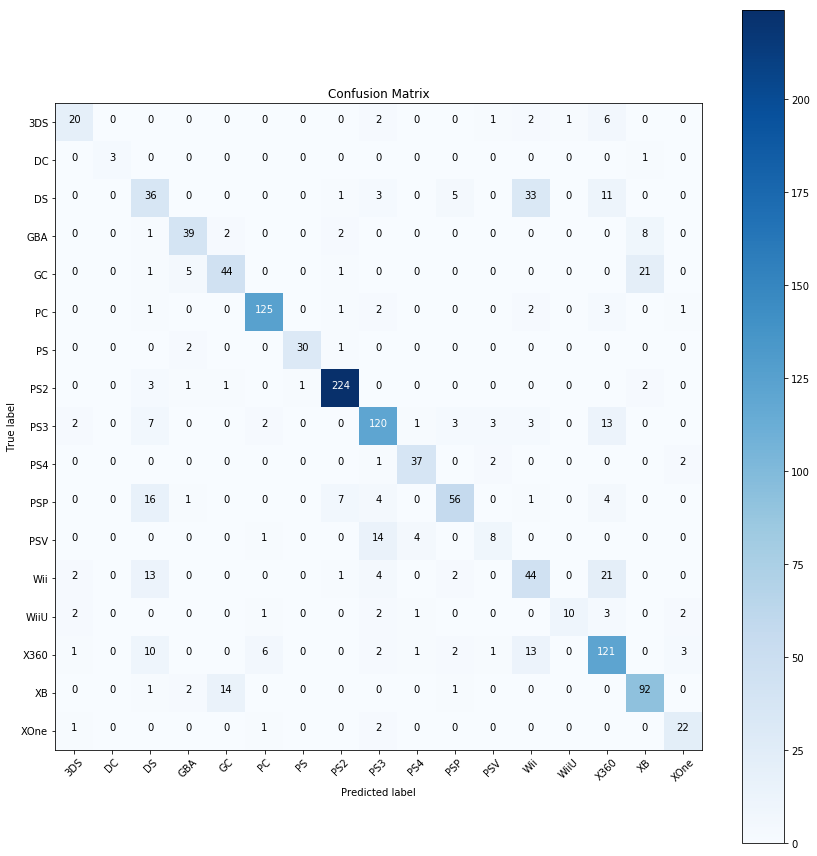

In [22]:
import sys
sys.path.insert(0, '../Data-Mining/')
from tools import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, model.predict(x_test))
print(accuracy_score(y_test, model.predict(x_test)))
print(cm)
plot_confusion_matrix(cm, classes=model.classes_, title='Confusion Matrix')

In [25]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

model = xgb.XGBClassifier()

random_search = RandomizedSearchCV(model, {'max_depth': list(range(0,3))}, n_iter=3, n_jobs=4, verbose=2, scoring=make_scorer(accuracy_score))

random_search.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=0 .....................................................
[CV] max_depth=0 .....................................................
[CV] max_depth=1 .....................................................
[CV] max_depth=0 .....................................................
[CV] ............................................ max_depth=0 -   2.4s
[CV] max_depth=1 .....................................................
[CV] ............................................ max_depth=0 -   2.5s
[CV] max_depth=1 .....................................................
[CV] ............................................ max_depth=0 -   2.6s
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=1 -   3.3s
[CV] max_depth=2 .....................................................
[CV] ............................................ max_depth=1 -   3.3s
[CV] max_depth=2 .

[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    6.7s remaining:    1.9s


[CV] ............................................ max_depth=2 -   4.0s
[CV] ............................................ max_depth=2 -   3.9s


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    9.6s finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=3, n_jobs=4,
          param_distributions={'max_depth': [0, 1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=make_scorer(accuracy_score), verbose=2)

### Power Law failled attenpts

In [ ]:
results = powerlaw.Fit(data=df['Global_Sales'])
print(results.power_law.alpha)
print(results.power_law.xmin)

In [ ]:
x = df['Global_Sales'].value_counts()
ax = plt.gca()
results.plot_pdf(ax=ax)
results.power_law.plot_pdf(ax=ax)

smallx = x[x.index > results.power_law.xmin]

print(np.sum(smallx.values))

plt.scatter(x.index, x.values/np.sum(smallx.values)*100, alpha=0.2)

#plt.xscale('log')
#plt.yscale('log')
plt.show()